In [ ]:
import os
from math import log10

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from skimage.transform import resize

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from sr_kspace import transforms as T
from sr_kspace.model import Generator, Discriminator
from sr_kspace.utils import SRKspaceData, gray2rgb, calculate_ssim, calculate_psnr, save_images
from sr_kspace.loss import GeneratorLoss
from sr_kspace.train import inference

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [ ]:
def tensor_for_model(tensor):
    tensor = tensor.transpose(-1, -2).transpose(-2, -3)
    tensor = tensor.unsqueeze(0)

    return tensor


def tensor_for_transform(tensor):
    tensor = tensor.transpose(-2, -3).transpose(-1, -2)
    tensor = tensor.squeeze(0)

    return tensor

In [ ]:
PATH_TO_SOURCE_TRAIN = 'data/ax_t2_source_train'
PATH_TO_SOURCE_VAL = 'data/ax_t2_source_val'
PATH_TO_SOURCE_TEST = 'data/ax_t2_source_test'

UPSCALE_FACTOR = 2
RANDOM_STATE = 42

In [ ]:
class SRGANMRIDataLoader(torch_data.Dataset):
    def __init__(self, path_to_data, seed=None):
        super().__init__()

        self.images = [os.path.join(path_to_data, file) for file in os.listdir(path_to_data) 
                       if file.endswith('.npy')]
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        slice = npy_load(self.images[idx])[0]
        resized = self.sample_resize(slice)

        return self.images[idx], slice_r, resized_tensor

In [6]:
train_set = SRKspaceData(PATH_TO_SOURCE_TRAIN, PATH_TO_LR_TRAIN)
val_set = SRKspaceData(PATH_TO_SOURCE_VAL, PATH_TO_LR_VAL)

train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=4)

len(train_loader.dataset), len(val_loader.dataset), 

(44082, 14697)

torch.FloatTensor torch.FloatTensor
torch.Size([1, 320, 320]) torch.Size([2, 160, 160])


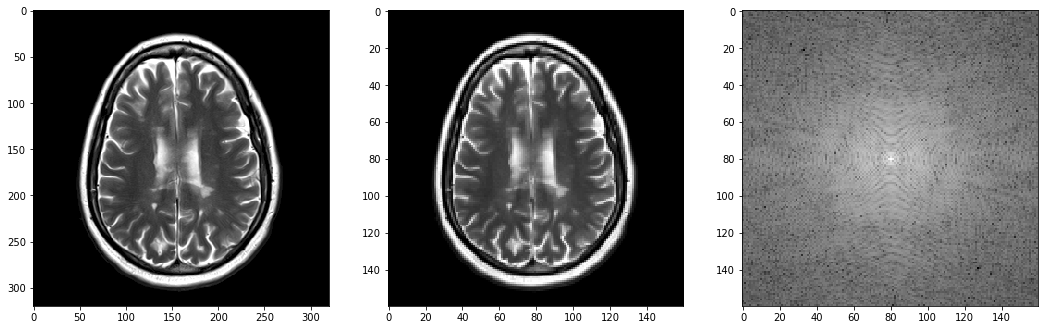

In [7]:
hr, lr = train_set.__getitem__(228)

print(hr.type(), lr.type())
print(hr.shape, lr.shape)

fig, axis = plt.subplots(1, 3, figsize=(18, 9))
axis[0].imshow(hr[0], cmap='gray')

lr_im = T.k_space_to_image(lr)
lr_im = T.fftshift(lr_im[0])

axis[1].imshow(lr_im, cmap='gray')
axis[2].imshow(torch.log(T.complex_abs(tensor_for_transform(lr))), cmap='gray')

In [8]:
h_HR = np.load(PATH_TO_HR_MEAN_KSPACE)
h_LR = np.load(PATH_TO_LR_MEAN_KSPACE)

h_HR = torch.from_numpy(h_HR)
h_LR = torch.from_numpy(h_LR)

if torch.cuda.is_available():
    h_HR = h_HR.cuda()
    h_LR = h_LR.cuda()

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

channels = 4
skipped_connection = True
bias = False

netG = Generator(UPSCALE_FACTOR, input_channels=2, output_channels=2, channels=channels, bias=bias)
netD = Discriminator(input_channels=1)

generator_criterion = GeneratorLoss()

if torch.cuda.is_available():
    netG.cuda()
    netD.cuda()
    generator_criterion.cuda()

optimizerG = optim.Adam(netG.parameters(), lr=1e-3)
optimizerD = optim.Adam(netD.parameters(), lr=1e-3)

Device: cpu


In [11]:
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': [], 'mae': []}
epochs = 15

bias_label = '_bias' if bias else ''
skip_label = '_skip' if skipped_connection else ''
label = f'{channels}_{UPSCALE_FACTOR}{bias_label}{skip_label}'
print('Model:', label)

out_path = f'results/{label}/'
os.makedirs(os.path.join(out_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(out_path, 'models'), exist_ok=True)


for epoch in range(1, epochs + 1):
    train_bar = tqdm(train_loader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    for hr_img, lr_kspace in train_bar:
        batch_size = hr_img.size(0)
        running_results['batch_sizes'] += batch_size

        # (1) Update D network: maximize D(x)-1-D(G(z))
        if torch.cuda.is_available():
            hr_img = hr_img.cuda()
            lr_kspace = lr_kspace.cuda()

        fake_img = inference(netG, lr_kspace, h_LR, h_HR, skipped_connection)

        netD.zero_grad()
        real_out = netD(hr_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        netG.zero_grad()
        g_loss = generator_criterion(fake_out, gray2rgb(fake_img), gray2rgb(hr_img))
        g_loss.backward()

        fake_img = inference(netG, lr_kspace, h_LR, h_HR, skipped_connection)
        fake_out = netD(fake_img).mean()

        optimizerG.step()

        # loss for current batch before optimization 
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, epochs, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))

        break


    netG.eval()
    val_bar = tqdm(val_loader)
    valing_results = {'mae': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}

    for i, (hr_img, lr_kspace) in enumerate(val_bar):
        batch_size = hr_img.size(0)
        valing_results['batch_sizes'] += batch_size
        if torch.cuda.is_available():
            hr_img = hr_img.cuda()
            lr_kspace = lr_kspace.cuda()

        sr_img = inference(netG, lr_kspace, h_LR, h_HR, skipped_connection)

        batch_mae = abs(sr_img - hr_img).data.mean().item()
        valing_results['mae'] += batch_mae * batch_size
        batch_ssim = calculate_ssim(sr_img, hr_img)
        valing_results['ssims'] += batch_ssim * batch_size
        valing_results['psnr'] = calculate_psnr(hr_img, sr_img, valing_results['batch_sizes'])
        valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
        val_bar.set_description(
            desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                valing_results['psnr'], valing_results['ssim']))

        break

    save_images(hr_img, sr_img, abs(sr_img - hr_img), 
                path=os.path.join(out_path, 'images', f'val_{label}_{epoch}.png'))
    

    torch.save(netG.state_dict(), 
               os.path.join(out_path, 'models', f'netG_epoch_{label}_{epoch}.pth'))
    torch.save(netD.state_dict(), 
               os.path.join(out_path, 'models', f'netD_epoch_{label}_{epoch}.pth'))


    results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
    results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
    results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
    results['psnr'].append(valing_results['psnr'])
    results['ssim'].append(valing_results['ssim'])
    results['mae'].append(valing_results['mae'])

    if epoch % 1 == 0:
        data_frame = pd.DataFrame(
            data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                  'Score_G': results['g_score'], 'PSNR': results['psnr'], 
                  'SSIM': results['ssim'], 'MAE': results['mae']},
            index=range(1, epoch + 1))

        data_frame.to_csv(os.path.join(out_path, f'metrics_val_{label}.csv'), 
                          index_label='Epoch')

Model: 4_2_skip
